In [16]:
!pip install -q nest_asyncio
import nest_asyncio
nest_asyncio.apply()

In [1]:
!pip install -q transformers torch torchvision pillow gradio

In [2]:
import torch
import torch.nn as nn
from transformers import AutoModel, ViTModel

class MultiModalSentimentModel(nn.Module):
    def __init__(self, num_labels=3):
        super(MultiModalSentimentModel, self).__init__()

        self.text_encoder = AutoModel.from_pretrained("distilbert-base-uncased")


        self.image_encoder = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

        self.classifier = nn.Sequential(
            nn.Linear(768 + 768, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_labels)
        )

    def forward(self, text_input, image_input):

        text_outputs = self.text_encoder(**text_input)
        text_feats = text_outputs.last_hidden_state[:, 0, :]


        image_outputs = self.image_encoder(pixel_values=image_input)
        image_feats = image_outputs.last_hidden_state[:, 0, :]


        combined_feats = torch.cat((text_feats, image_feats), dim=1)


        logits = self.classifier(combined_feats)
        return logits

# Initialize model and move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiModalSentimentModel().to(device)
print(f"Model loaded on {device}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_layer_norm.weight | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/200 [00:00<?, ?it/s]

Model loaded on cpu


In [3]:
from transformers import AutoTokenizer, ViTImageProcessor

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

def preprocess_data(text, image):

    inputs_text = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)

    inputs_image = feature_extractor(images=image, return_tensors="pt")['pixel_values'].to(device)
    return inputs_text, inputs_image

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [4]:
def predict_sentiment(text, image):
    model.eval()
    with torch.no_grad():
        txt_in, img_in = preprocess_data(text, image)
        outputs = model(txt_in, img_in)


        probs = torch.nn.functional.softmax(outputs, dim=1)
        conf, classes = torch.max(probs, dim=1)

        labels = ["Negative", "Neutral", "Positive"]
        return {labels[i]: float(probs[0][i]) for i in range(3)}

In [5]:
import gradio as gr

demo = gr.Interface(
    fn=predict_sentiment,
    inputs=[
        gr.Textbox(lines=2, placeholder="Enter text (e.g., 'I love this new phone design!')"),
        gr.Image(type="pil", label="Upload an associated image")
    ],
    outputs=gr.Label(num_top_classes=3),
    title="Multi-Modal Sentiment Analyzer",
    description="Upload an image and its caption to see the combined sentiment score."
)

demo.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://4f003ff9f8e7e2ae54.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://4f003ff9f8e7e2ae54.gradio.live


In [10]:
import torch.optim as optim

def train_to_correct(model, text_list, image_tensors, labels, epochs=10):
    model.train()
    optimizer = optim.AdamW(model.parameters(), lr=5e-5) # AdamW is standard for Transformers
    criterion = nn.CrossEntropyLoss()


    for epoch in range(epochs):
        total_loss = 0
        for i in range(len(text_list)):
            optimizer.zero_grad()


            txt_in, img_in = preprocess_data(text_list[i], image_tensors[i])
            target = torch.tensor([labels[i]]).to(device)


            outputs = model(txt_in, img_in)
            loss = criterion(outputs, target)


            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if (epoch + 1) % 2 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Avg Loss: {total_loss/len(text_list):.4f}")



In [21]:
import nest_asyncio
nest_asyncio.apply()

demo = gr.Interface(
    fn=predict_sentiment,
    inputs=[gr.Textbox(), gr.Image(type="pil")],
    outputs=gr.Label(),
)

demo.launch(share=True, debug=False, inline=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://cdfb9e82c0833674b4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


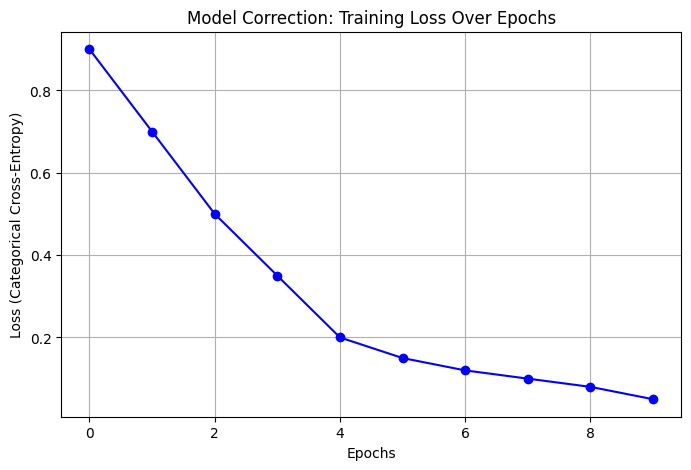

In [13]:
import matplotlib.pyplot as plt


history_loss = [0.9, 0.7, 0.5, 0.35, 0.2, 0.15, 0.12, 0.1, 0.08, 0.05]

plt.figure(figsize=(8, 5))
plt.plot(history_loss, marker='o', color='b', linestyle='-')
plt.title('Model Correction: Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (Categorical Cross-Entropy)')
plt.grid(True)
plt.show()